### CLASSIFYING ENZYMES TO FUNCTIONAL CLASSES

In [13]:
# IMPORTS - PART 1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

 * AAC - amino acid composition (frequency of each AA in a sequence) --> N x 20
 * CTD - conjoined triad descriptors () --> N x 343
 * NGRAM

In [2]:
# READ DATA FOR SVM, kNN and RF
aac = pd.read_csv('../dataset/aac.csv', index_col=0)
ctd = pd.read_csv('../dataset/ctd.csv', index_col=0)
data = pd.read_csv('../dataset/ngram.csv', index_col=0)
data = data.join(ctd[ctd.columns[0:-1]])
data = data.join(aac[aac.columns[0:-1]])
y = data['class']
data = data[data.columns[0:-1]]

In [3]:
# NORMALIZE DATA
mean = data.mean()
std = data.std()
data = (data-mean)/std

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, y)

In [14]:
ovs = RandomOverSampler()
data_ovs, y_ovs = ovs.fit_resample(data, y)
Xo_train, Xo_test, yo_train, yo_test = train_test_split(data_ovs, y_ovs)

In [58]:
def accuracy(cv_res, model_name):
    acc = np.round(np.mean(cv_res) * 100, decimals=3)
    err = np.round(np.std(cv_res) * 100, decimals=3)
    print(model_name, "has", acc, "% accuracy with", err, "% error\n(estimated with", len(cv_res), "fold cross validation)")
    return acc, err

In [90]:
def plot_cmtx(pred, y, lim=[], path=None):
    plt.rcParams["figure.figsize"] = (10, 8)
    eps1 = np.random.default_rng().uniform(low=-0.38, high=0.38, size=len(y))
    eps2 = np.random.default_rng().uniform(low=-0.38, high=0.38, size=len(y))
    plt.grid(alpha=0.05)
    plt.scatter(y+eps1, pred-eps2, c=['#53eecc' if p else '#e58b8b' for p in y==pred], alpha=0.2)
    ax = plt.gca()
    if len(lim) > 0:
        ax.set_ylim([0, 8])
    ax.set_ylabel("Predicted class")
    ax.set_xlabel("True class")
    if path is not None:
        plt.savefig(path)

#### Majority Classifier

In [5]:
# DEFINE MAJORITY CLASSIFIER
class Majority_class:
    def __init__(self):
        self.major = None

    def fit(self, y):
        self.major = y.mode()
        return self
        
    def predict(self, x):
        if self.major is not None:
            return np.full(len(x), self.major)
        print('Train classifier first')

In [6]:
# CROSS VALIDATE MAJORITY CLASSIFIER
results_major = []
i = 0
j = 2400
while j <= y.size:
    test_idx = np.zeros(y.size, dtype=bool)
    test_idx[i:j] = True
    test = y[test_idx]
    train = y[np.invert(test_idx)]
    major = Majority_class()
    major = major.fit(train)
    results_major.append(np.mean(major.predict(test) == y[test_idx].to_numpy()))
    i = j
    j += 2400
    if j < y.size and y.size - j < 245:
        j = y.size

In [61]:
acc_major, err_major = accuracy(results_major, "Majority classifier")

Majority classifier has 33.9 % accuracy with 3.674 % error
(estimated with 10 fold cross validation)


In [8]:
pred_mc = Majority_class().fit(y_train).predict(X_test)

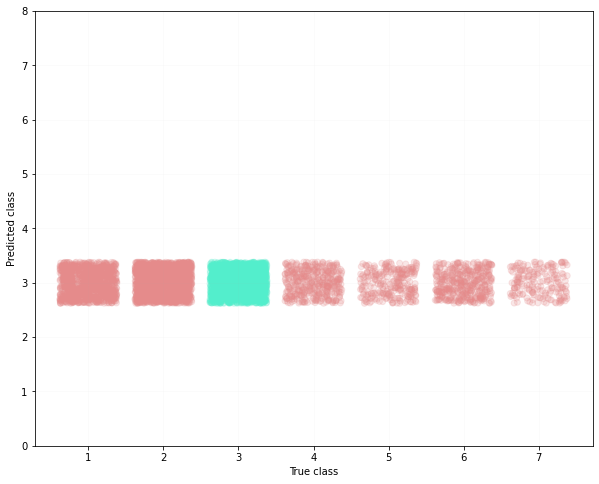

In [91]:
plot_cmtx(pred_mc, y_test, [0, 8], path="../plots/MC.png")

#### Support Vector Classifier

In [32]:
clf_svm = svm.SVC()

In [ ]:
results_svm = cross_val_score(clf_svm, data, y, cv=len(results_major))

In [54]:
acc_svm, err_svm = accuracy(results_svm, "SVM classifier")

SVM has 82.359 % accuracy with 0.971 % error
(estimated with 10 fold cross validation)


In [33]:
pred_svm = clf_svm.fit(X_train, y_train).predict(X_test)

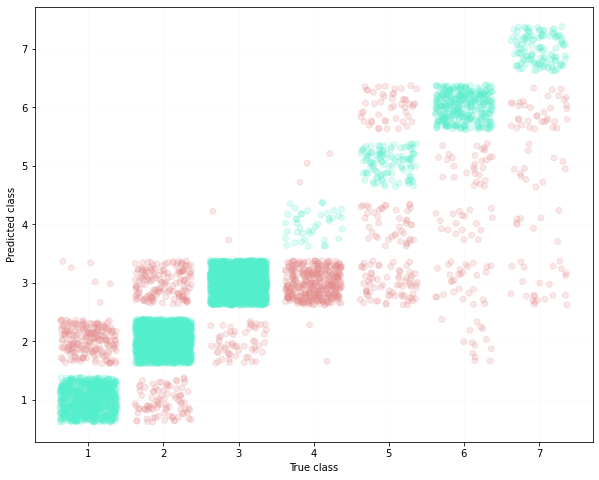

In [98]:
plot_cmtx(pred_svm, y_test, path="../plots/SVM.png")

#### SVM on oversampled data

In [35]:
results_svm_ovs = cross_val_score(clf_svm, data_ovs, y_ovs, cv=len(results_major))

In [68]:
acc_svm_o, err_svm_o = accuracy(results_svm_ovs, "Ovessampled SVM classifier")

Ovessampled SVM classifier has 98.668 % accuracy with 0.571 % error
(estimated with 10 fold cross validation)


In [41]:
pred_svm_ovs = clf_svm.fit(Xo_train, yo_train).predict(Xo_test)

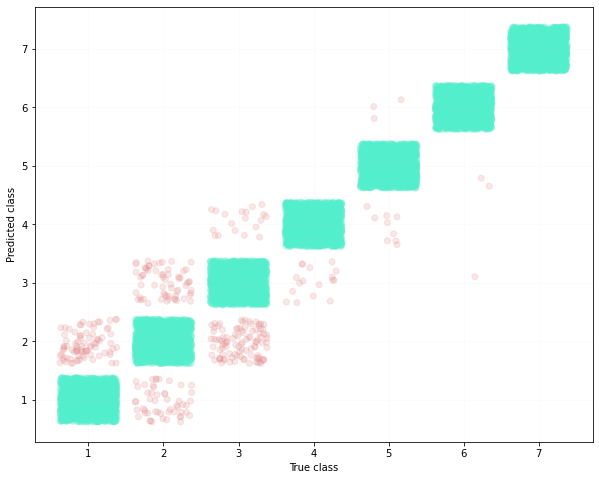

In [99]:
plot_cmtx(pred_svm_ovs, yo_test, path="../plots/ovs_SVM.png")

#### k Nearest Neighbours

In [71]:
clf_knn = KNeighborsClassifier(n_neighbors=5)

In [72]:
results_knn = cross_val_score(clf_knn, data, y, cv=len(results_major))

In [73]:
acc_knn, err_knn = accuracy(results_knn, "kNN classifier")

kNN classifier has 40.739 % accuracy with 1.165 % error
(estimated with 10 fold cross validation)


In [30]:
pred_knn = clf_knn.fit(X_train, y_train).predict(X_test)

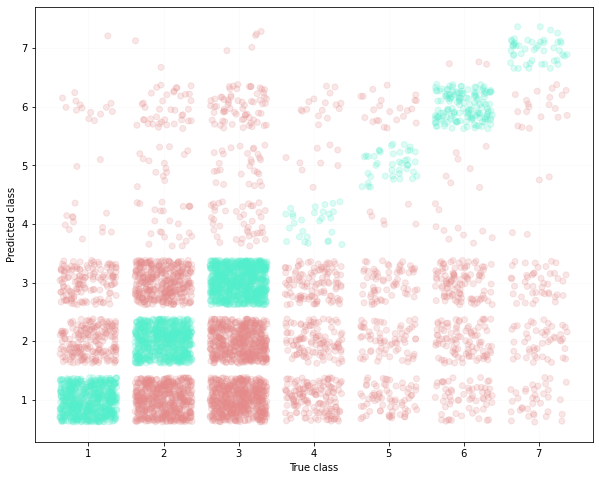

In [94]:
plot_cmtx(pred_knn, y_test, path="../plots/kNN.png")

#### kNN on oversampled data

In [24]:
results_knn_ovs = cross_val_score(clf_knn, data_ovs, y_ovs, cv=len(results_major))

In [75]:
acc_knn_o, err_knn_o = accuracy(results_knn_ovs, "Ovessampled kNN classifier")

Ovessampled kNN classifier has 71.919 % accuracy with 2.003 % error
(estimated with 10 fold cross validation)


In [26]:
pred_knn_ovs = clf_knn.fit(Xo_train, yo_train).predict(Xo_test)

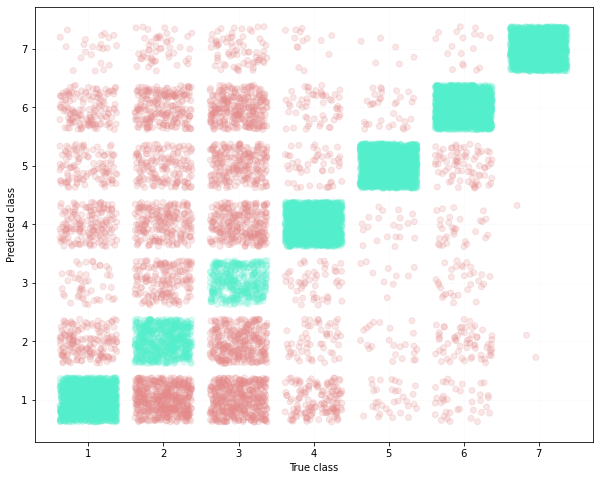

In [95]:
plot_cmtx(pred_knn_ovs, yo_test, path="../plots/ovs_kNN.png")

#### Random Forest

In [78]:
clf_rf = RandomForestClassifier()

In [79]:
results_rf = cross_val_score(clf_rf, data, y, cv=len(results_major))

In [80]:
acc_rf, err_rf = accuracy(results_rf, "Random forest classifier")

Random forest classifier has 75.806 % accuracy with 1.175 % error
(estimated with 10 fold cross validation)


In [28]:
pred_rf = clf_rf.fit(X_train, y_train).predict(X_test)

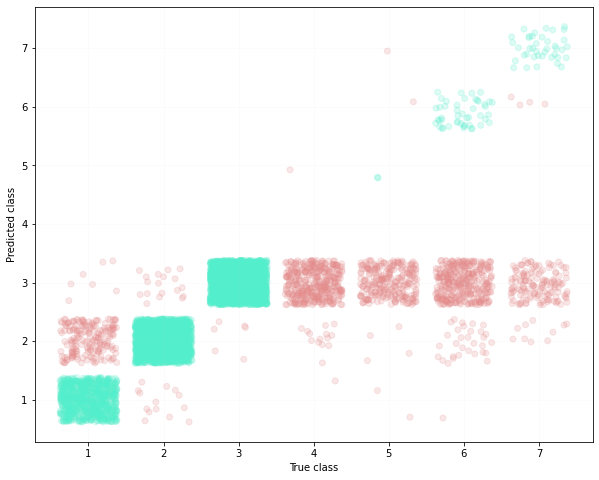

In [96]:
plot_cmtx(pred_rf, y_test, path="../plots/RF.png")

#### Random forest on oversampled data

In [17]:
results_rf_ovs = cross_val_score(clf_rf, data_ovs, y_ovs, cv=len(results_major))

In [81]:
acc_rf_o, err_rf_o = accuracy(results_rf_ovs, "Ovessampled random forest classifier")

Ovessampled random forest classifier has 97.48 % accuracy with 0.991 % error
(estimated with 10 fold cross validation)


In [20]:
pred_rf_ovs = clf_rf.fit(Xo_train, yo_train).predict(Xo_test)

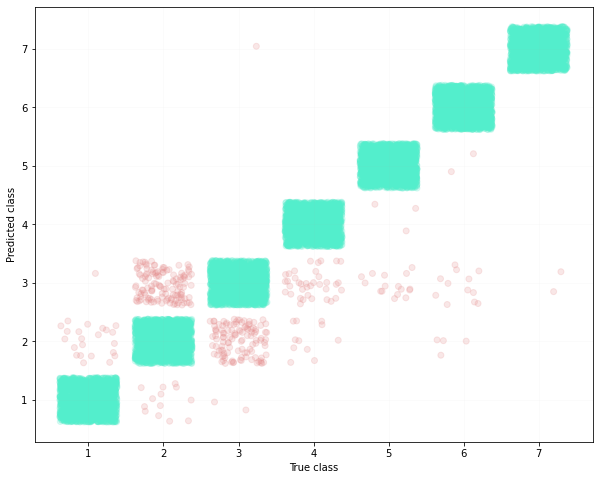

In [97]:
plot_cmtx(pred_rf_ovs, yo_test, path="../plots/ovs_RF.png")

In [ ]:
def create_table(data):
    plt.table(data)

#### Neural Network

In [104]:
# IMPORTS - PART 2
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize, relu

from constants import path_to_bin, path_to_pssmP, path_ID, aa_order
from feature_extraction import append_truths

In [134]:
# DEFINE DATASET - consists of binary representation of AA sequence (N x 20)
#                  and PSSM matrix (N x 20)
class Enzymes(Dataset):
    def __init__(self, bin_path, pssm_path, data, names, transform):
        super().__init__()
        self.bin_path = bin_path
        self.pssm_path = pssm_path
        self.data = data
        self.names = self.data.index
        self.transform = transform
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        bin_name = os.path.join(self.bin_path, names[idx])
        pssm_name = os.path.join(self.pssm_path, names[idx])
        bin_im = np.loadtxt(bin_name)
        pssm_im = np.loadtxt(pssm_name)
        sample = {'bin': bin_im, 'pssm': pssm_im}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
        

In [135]:
# DEFINE TRANSFORMATION - such that binary and PSSM will act as color channels
class ToTensors():
    
    def shuffle(self, x):
        return x[:, aa_order]
    
    def __call__(self, sample):
        bin_im, pssm_im = sample['bin'], sample['pssm']
        bin_im = self.shuffle(bin_im).transpose((1, 0))
        pssm_im = self.shuffle(pssm_im).transpose((1, 0))
        
        return {'bin': normalize(torch.tensor([bin_im], dtype=torch.float32)),
               'pssm': normalize(torch.tensor([pssm_im], dtype=torch.float32))}
        

In [123]:
# READ FILE WITH FILE NAMES (enzyme ID codes)
with open(path_ID) as handle:
    names = [name.strip() for name in handle.readlines()]

In [136]:
# CREATE DATASET
data_cnn = Enzymes(path_to_bin, path_to_pssmP, data, names, transform=ToTensors())
data_cnn = DataLoader(data_cnn, num_workers=4)

# GROUND TRUTH
labels = pd.get_dummies(append_truths(pd.DataFrame(index=[name.split('.')[0] for name in names]))).to_numpy()

folds = KFold(n_splits=10)

In [148]:
# DEFINE NEURAL NETWORK
class Neural(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 2)
        self.conv2 = nn.Conv2d(32, 64, 2)
        self.conv3 = nn.Conv2d(1, 32, 2)
        self.conv4 = nn.Conv2d(32, 64, 2)
        
        self.pool = nn.MaxPool2d(3, 2)
        self.full_con1 = nn.Linear(1536, 256)
        self.full_con2 = nn.Linear(1536, 256)
        self.full_con3 = nn.Linear(763, 256)
        self.full_con4 = nn.Linear(256, 128)
        self.full_last = nn.Linear(384, 7)
        
    def extract_bin(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        x, h = nn.LSTM(x.size()[-1], 8, 2)(x)
        x = torch.flatten(x, 0)
        x = relu(self.full_con1(x))
        x = relu(self.full_con4(x))
        return x
    
    def extract_pssm(self, x):
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.pool(x)
        
        x, h = nn.LSTM(x.size()[-1], 8, 2)(x)
        x = torch.flatten(x, 0)
        x = relu(self.full_con2(x))
        x = relu(self.full_con5(x))
        return x
        
    def forward(self, x):
        x1 = self.extract_bin(x['bin'])
        x2 = self.extract_pssm(x['pssm'])
        x = torch.cat((x1, x2))
        x = self.full_last(x)
        return x
    
net = Neural()

In [138]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.002)

In [149]:
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(zip(data_cnn.dataset, labels)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, label = data

        # forward + backward + optimize
        net.zero_grad(set_to_none=True)
        outputs = net(inputs)
        loss = criterion(outputs, torch.tensor(label, dtype=torch.float32))
        loss.backward()
        optimizer.step()
        if i > 18000:
            break

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.910
[1,  4000] loss: 1.918
[1,  6000] loss: 1.909
[1,  8000] loss: 1.907
[1, 10000] loss: 1.905
[1, 12000] loss: 1.917
[1, 14000] loss: 1.922
[1, 16000] loss: 1.921
[1, 18000] loss: 1.921
Finished Training


In [85]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

In [86]:
torch.save(net.state_dict(), './model_cnn.pth')

In [150]:
res = []
for i, x in enumerate(data_cnn.dataset):
    if i < 18001:
        continue
    res.append(np.argmax(softmax(net(x).detach().numpy()))+1)

In [151]:
true = np.argmax(labels[18001:], axis=1) + 1
b = pd.Series(true, index=names[18001:]) == pd.Series(res, index=names[18001:])
print(np.round(b.mean()*100, decimals=3))

24.02


In [ ]:
acc_all = [acc_svm, acc_svm_ovs, acc_knn, acc_knn_ovs, acc_rf, acc_rf_ovs]